## Here will be a description of the exponential fit


In [1]:
# imports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.optimize import fsolve, curve_fit  # , minimize
import seaborn as sns
from scipy.optimize import minimize_scalar

from load_data_scripts import load_save_profiles
from load_data_scripts import save_unique_profile_customer

Loading all the data. The profiles contain the leapday of 2020 whereas the customers somehow do not, so we remove those.
Filtering all customers with double profiles and customers that either joined Alliander after the first month or quit their subscription one month prior to the end of the year, we're left with 3821 customers

In [2]:
# read data and clean (this takes some time)
customers = save_unique_profile_customer.unique_customer(reload=1, nrows=5000)
connection, profiles = load_save_profiles.load_profiles()

Find a, b such that:
\begin{align*}
a*profile^b &= SJV \\
\max{a*profile^b} &= \max{customer}
\end{align*}
Note that this takes quite some time.
Also: we always first take power, then multiply (this is seemingly arbitrary thing important to note due to python datastructure)

In [60]:
# aims to find optimal a and b for exponential fitting
def optimal_parameters2(profile, customer):

    b = 1
    a = 1
    SJV = customer.sum()
    profile_estimate = profile*SJV
    for i in range(1):

        guess_b = np.log(customer.max())/np.log(profile_estimate.max())
        
        print('whithin this function i find cust.max and prof.max: ', customer.max(), profile_estimate.max())
        print('and the guess for b is ', guess_b)

        def exp_eq(var_a):
            SJV_error = (sum(var_a*(profile_estimate.pow(guess_b))) - SJV)
            return SJV_error

        b = b * guess_b
        res = fsolve(exp_eq, 1)
        a = a * res
        
        print("new a and b are: ", a, b)
        print("guessed a is ", res)
        print("minimization error is ", exp_eq(res))

        profile_estimate = a * profile.pow(b)
    
    return a, b

# # aims to find optimal a and b for exponential fitting
# def optimal_parameters(profile, customer):

#     def exp_eq(x):
#         a, b = x
#         SJV = customer.sum()
#         norm_max = np.log(customer.max())/np.log(SJV*profile.max())
#         SJV_error = SJV*((a*profile).pow(b*norm_max).sum() - 1)
#         max_error = SJV*((a*profile.max())**(b*norm_max) -
#                          customer.max()/SJV)
#         return (SJV_error, max_error)

#     SJV = customer.sum()
#     guess_b = 1 # (np.amax(customer)/customer.sum())/np.amax(profile)
#     # guess_b = np.log(customer.max()/SJV)/np.log(profile.max())
#     # guess_a = customer.sum()/profile.pow(guess_b).sum()
#     guess_a = 1 #/profile.pow(guess_b).sum()
#     guess = (guess_a, guess_b)

# #     print('initial guesses (a,b); ', guess)

#     a, b = fsolve(exp_eq, guess, factor=0.3)

# #     print('result of error function(should be around (0,0)): ')
#     # print('error: ', exp_eq((a, b)))
#     # print('guess (a,b): ',  guess)
#     # print('actual: ', (a,b))
#     return a, b

Apply everything and see if it works

total amount of customers: 
3821
now already beyond 0th customer
whithin this function i find cust.max and prof.max:  44.0 21.654316623713587
and the guess for b is  1.2305488120103367
new a and b are:  [0.56560969] 1.2305488120103367
guessed a is  [0.56560969]
minimization error is  -8.731149137020111e-10
a, b:  [0.56560969] 1.2305488120103367
max customer 44.0
new max est profile:  21.82290514568318


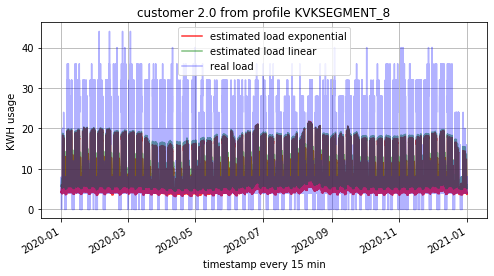

whithin this function i find cust.max and prof.max:  152.0 111.72213680877839
and the guess for b is  1.0652808912068965
new a and b are:  [0.77196815] 1.0652808912068965
guessed a is  [0.77196815]
minimization error is  -5.587935447692871e-09
a, b:  [0.77196815] 1.0652808912068965
max customer 152.0
new max est profile:  115.3733113650197


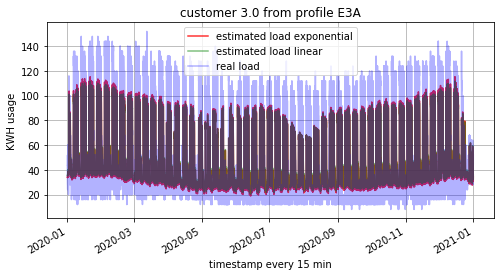

whithin this function i find cust.max and prof.max:  516.0 267.5828592217429
and the guess for b is  1.1174856073845594
new a and b are:  [0.57821321] 1.1174856073845594
guessed a is  [0.57821321]
minimization error is  6.05359673500061e-09
a, b:  [0.57821321] 1.1174856073845594
max customer 516.0
new max est profile:  279.7605500341687


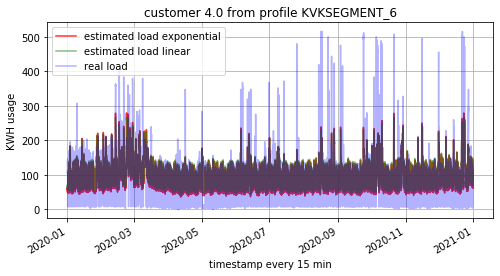

whithin this function i find cust.max and prof.max:  52.0 32.04200927849469
and the guess for b is  1.1396565349757626
new a and b are:  [0.68194638] 1.1396565349757626
guessed a is  [0.68194638]
minimization error is  4.656612873077393e-10
a, b:  [0.68194638] 1.1396565349757626
max customer 52.0
new max est profile:  33.61520067726063


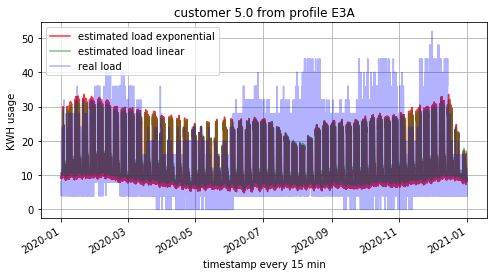

whithin this function i find cust.max and prof.max:  88.0 33.64501168490587
and the guess for b is  1.2734667184757975
new a and b are:  [0.45448746] 1.2734667184757975
guessed a is  [0.45448746]
minimization error is  -2.3283064365386963e-10
a, b:  [0.45448746] 1.2734667184757975
max customer 88.0
new max est profile:  32.2365250141547


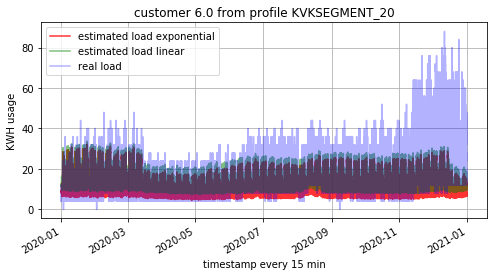

In [61]:
# improvement_lis = [0]*customers.index.size
print('total amount of customers: ')
print(customers.index.size)
count = 0

profile_parameters = pd.DataFrame(columns=['profile', 'a', 'b'])
# store estimated a, b in new list

for customer_id in customers.index:
    if count == 5: break
    if count % 100 == 0:
        print('now already beyond {}th customer'.format(count))
        if count == 300: break
    # find corresponding profile
    profile_type = connection.loc[customer_id, 'BASELOAD_PROFILE']

    profile_customer = profiles[profile_type]
    customer = customers.loc[customer_id]

    res = optimal_parameters2(profile_customer, customer)

    a, b = res
    
    SJV = customer.sum()
    print("a, b: ", a, b)
    
    est_exp_load = (a*SJV*profile_customer).pow(b)
    # est_exp_load = a*customer.sum()*(profile_customer.pow(b))
    print('max customer', np.amax(customer))
    print('new max est profile: ', np.amax(est_exp_load))
    est_lin_load = SJV*profile_customer
    
    plt.figure(figsize=(8, 4))
    plt.xlabel('timestamp every 15 min')
    plt.ylabel('KWH usage')

    plt.title("customer {} from profile {}".format(
        customer_id, profile_type))
    ax1 = est_exp_load.plot.line(color='red', grid=True,
                                 label="estimated load exponential",
                                 alpha=0.8)
    ax2 = est_lin_load.plot.line(color='green', grid=True,
                                 label="estimated load linear",
                                 alpha=0.5)
    ax3 = customer.plot.line(color='blue', grid=True,
                             label="real load",
                             alpha=0.3)

    plt.legend()
    plt.show()
    
    para_dict = {'profile': profile_type,
                'a': a,
                'b': b}
    profile_parameters = profile_parameters.append(para_dict, ignore_index=True)
    count += 1
    
    
    
# too lazy to check screen: notify me when done
try:
    import os
    duration = 0.5  # seconds
    freq = 600  # Hz
    os.system('play -nq -t alsa synth {} sine {}'.format(duration, freq))
except _:
    import winsound
    duration = 1000  # milliseconds
    freq = 440  # Hz
    winsound.Beep(freq, duration)


0


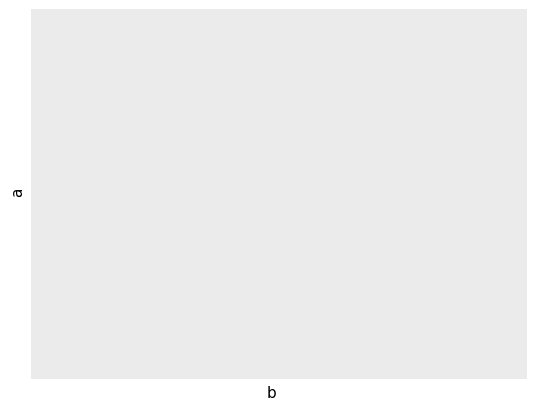

In [29]:
from plotnine import *

profile_parameters = profile_parameters[profile_parameters['b'] < 15]
profile_parameters = profile_parameters[profile_parameters['b'] > -10]
profile_parameters = profile_parameters[profile_parameters['a'] < 10**10]


palette = sns.color_palette("Set2", len(profile_parameters))
color_map = dict(zip(profile_parameters['profile'], palette))
print(len(profile_parameters))

g = ggplot(profile_parameters, aes(x='b', y='a', color='profile')) + geom_point(stat='summary')
print(g)

In [26]:
# fitting th curve above
x = profile_parameters['b']
y = profile_parameters['a']
new_parameters = curve_fit(lambda t,a,b: a*np.exp(b*t),  x,  y, p0=(5, 10))
new_a, new_b = new_parameters[0]
print(new_a, new_b)

ValueError: `ydata` must not be empty!

In [ ]:
def fun(x):
    return new_a*np.exp(new_b*x)

lists = sorted(zip(*[x, y]))
new_x, new_y = list(zip(*lists))
new_x, new_y = np.array(new_x), np.array(new_y)

plt.plot(new_x, fun(new_x), label='fitted line')
plt.scatter(new_x, new_y, label='calculated line')
plt.legend()
plt.show()

max norm_customer:  0.00011760177899418406
max profile:  5.787695813300116e-05
SJV:  374144.0
max customer 44.0
new max est profile:  15.997606913053184


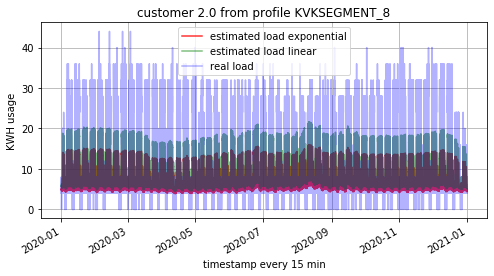

max norm_customer:  8.868951899939551e-05
max profile:  6.51880432576001e-05
SJV:  1713844.0
max customer 152.0
new max est profile:  70.22505596299342


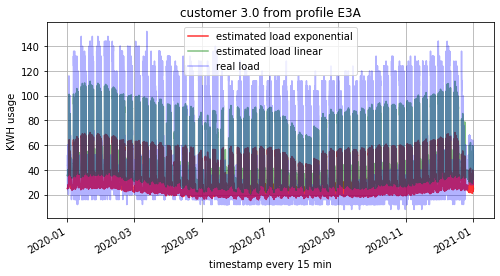

max norm_customer:  0.00014232927933941562
max profile:  7.380789828800575e-05
SJV:  3625396.0
max customer 516.0
new max est profile:  154.33546646998423


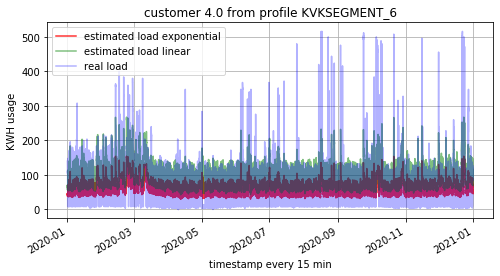

max norm_customer:  0.00010579168802844982
max profile:  6.51880432576001e-05
SJV:  491532.0
max customer 52.0
new max est profile:  22.775917209172235


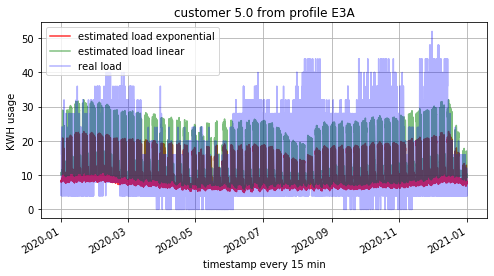

max norm_customer:  0.0001500948326442616
max profile:  5.7385709070001953e-05
SJV:  586296.0
max customer 88.0
new max est profile:  23.800687564579377


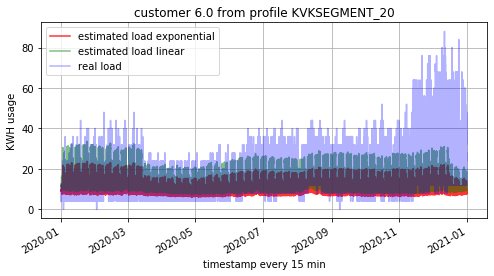

In [27]:
from dtaidistance import dtw
# from dtaidistance import dtw_visualisation as dtwvis
from scipy.stats import wasserstein_distance

new_count = 0

for customer_id in customers.index:
    if new_count == 5:
        break
        
    profile_type = connection.loc[customer_id, 'BASELOAD_PROFILE']

    profile_customer = profiles[profile_type]
    customer = customers.loc[customer_id]
    
    SJV = customer.sum()
    #norm_max = np.log(customer.max())/np.log(SJV*profile_customer.max())
    #print('norm_max: ', norm_max)
    # norm_max = np.log(customer.max()/SJV)/np.log(profile_customer.max())
    #guess_b = np.log(customer.max()/SJV)/np.log(profile_customer.max())
    # guess_b = (np.amax(customer))/np.amax(profile_customer*SJV)
    print('max norm_customer: ', np.amax(customer)/customer.sum())
    print('max profile: ', np.amax(profile_customer))
    #print('guess b: ', guess_b)
    
    #guess_a = fun(guess_b)
    #print('guess a: ', guess_a)
    print("SJV: ", SJV)
        
    est_exp_load = (SJV*profile_customer).pow(guess_b)
    # est_exp_load = a*customer.sum()*(profile_customer.pow(b))
    print('max customer', np.amax(customer))
    print('new max est profile: ', np.amax(est_exp_load))
    est_lin_load = customer.sum()*profile_customer
    
    plt.figure(figsize=(8, 4))
    plt.xlabel('timestamp every 15 min')
    plt.ylabel('KWH usage')

    plt.title("customer {} from profile {}".format(
        customer_id, profile_type))
    ax1 = est_exp_load.plot.line(color='red', grid=True,
                                 label="estimated load exponential",
                                 alpha=0.8)
    ax2 = est_lin_load.plot.line(color='green', grid=True,
                                 label="estimated load linear",
                                 alpha=0.5)
    ax3 = customer.plot.line(color='blue', grid=True,
                             label="real load",
                             alpha=0.3)

    plt.legend()
    plt.show()
    
#     dtw_exp_dist = dtw.distance(customer, est_exp_load, use_pruning=True)
#     dtw_lin_dist = dtw.distance(customer, est_lin_load, use_pruning=True)
    
#     wass_exp_dist = wasserstein_distance(customer, est_exp_load)
#     wass_lin_dist = wasserstein_distance(customer, est_lin_load)
    
#     print('Dynamic Time Warping Distance customer, exp_load: ', dtw_exp_dist)
#     print('Dynamic Time Warping Distance customer, lin_load: ', dtw_lin_dist)
    
#     print('Wasserstein distance customer, exp_load: ', wass_exp_dist)
#     print('Wasserstein distance customer, lin_load: ', wass_lin_dist)
    new_count += 1
    
    
    

In [4]:
print(len(customers.index))
print(customers.index)

3821
Float64Index([   2.0,    3.0,    4.0,    5.0,    6.0,    7.0,    8.0,    9.0,
                10.0,   12.0,
              ...
              4987.0, 4989.0, 4990.0, 4991.0, 4992.0, 4993.0, 4995.0, 4997.0,
              4998.0, 5000.0],
             dtype='float64', length=3821)
